# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science 

## Lab 5: Cross-validation, Bootstrap, and Regularization 

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb<br/>
<hr style='height:2px'>

**Material preparation**: Robert Roessler, Queenie Luo, and Chris Gumb

In [1]:
# Data and Stats packages
import numpy as np
import pandas as pd
#pd.set_option('max_columns', 200)

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
#from prettytable import PrettyTable

In [2]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import sys

In [3]:
# Some global matplotlib settings
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Times New Roman"],
    "figure.dpi" : 100})

# to display nice pipeline drawing
from sklearn import set_config
set_config(display="diagram") # instead of display='text'
pd.set_option('display.max_columns', None)

<a id=top></a>
### Lab Overview

- [1 - Cross Validation](#cv)<BR>
- [2 - Bootstrapping](#boot)<BR>
- [3 - Confidence Intervals](#ci)<BR>
- [4 - Feature importance](#feature)<BR>
- [5 - Linear Regression Coefficient interpretation](#coeff_interpretation)<BR>
- [6 - Model Selection review with an example of ridge and lasso regression using cross validation.](#model)<BR>

### The dataset
We are revisiting the dataset from last week's lab, which focused on Premier League Soccer Data. With this dataset, our primary objective was to predict the market value of Premier League players, denominated in millions of pounds, based on a variety of features.

In the previous lab, you learned about the critical preparatory steps before model training. This involved feature engineering, where transformations such as `OneHotEncoder()` might be applied to handle categorical data. We also introduced the `PolynomialFeatures()` method, which allowed us to generate higher-degree features as well as interaction terms, capturing relationships between different features. Most importantly, we emphasized the importance of standardizing the features using techniques like the `StandardScaler()` to ensure that our model treats all features on a common scale. The data we're loading now is the outcome of those efforts.

In [4]:
# Loading the data
design_train_df = pd.read_csv("data/design_train_df.csv")
y_train = pd.read_csv("data/y_train.csv")  # you could add .values.ravel() to make sure y_train is a 1D array

design_test_df = pd.read_csv("data/design_test_df.csv")
y_test = pd.read_csv("data/y_test.csv")

display(design_train_df.head(5))

,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,-0.378867,-0.705517,-0.689254,0.143541,0.267297,0.261136,0.497754,0.486280,0.475071,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.649806,-0.782937,-0.689254,0.422248,0.508758,0.447882,0.612991,0.539642,0.475071,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.090449,0.533214,0.074738,0.008181,-0.048228,-0.006760,0.284317,0.039852,0.005586,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.558494,1.636458,-0.434590,0.311916,0.913952,-0.242716,2.677993,-0.711188,0.188868,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.271168,2.352598,-0.434590,0.073532,0.637948,-0.117847,5.534719,-1.022415,0.188868,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<div id=cv style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>1 - Cross Validation</h1> 


### Intro

Cross-validation is a technique for evaluating predictive models. In k-fold cross-validation, the dataset is divided into k subsets or folds. The model is trained and evaluated k times, using a different fold as the validation set each time. Performance metrics from each fold are averaged to estimate the model's generalization performance.


<img src="fig/cross_val.png" alt="alt text" width="500" height="300" class="blog-image">



---

### Key Points for Cross Validation

<div style="padding-top:0px;"></div>

1. **Role of Training, Validation, and Test Sets:**
    - **Key Takeaway:** The training set is used to fit candidate models, their performance on the validation set is used to select from among candidates, and the selected model's performance is finally evaluated on the test set.
    - **Rationale:** Use of a validation set for model selection prevents overfitting to the training data. A separate test set helps us estimate the selected model's performance on previously unseen data.

<div style="padding-top:0px;"></div>

2. **$k$-Fold Cross Validation:**
    - **Key Takeaway:** One common method of model selection is $k$-Fold cross-validation where the original training data is partitioned into $k$ subsets or 'folds.' The model is trained on $k$-1 folds and validated on the remaining one. This process is repeated K times.
    - **Rationale:** By rotating the validation set through all data points, we can get a more robust measure of model performance.

<div style="padding-top:0px;"></div>

3. **Choosing the Right Number of Folds:**
    - **Key Takeaway:** The choice of $k$ in $k$-Fold cross-validation is crucial. Common choices are 5 or 10, but the optimal number may vary depending on the dataset size and specific problem.
    - **Rationale:** A smaller $k$ will result in larger validation sets, which gives more accurate estimates of model performance but with higher variance. A larger $k$ provides smaller validation sets, leading to a less accurate model performance estimate but with lower variance.

---

### Manual Implementation of k-fold Cross-Validation

In [5]:
# K-Fold cross-validation

# Number of partitions/folds to divide the dataset into
k_folds = 8

# Calculate the size of each fold. If the dataset's length isn't 
# perfectly divisible by k, some folds might have an extra data point.
fold_size = len(design_train_df) // k_folds

# This list will store the mean squared error for each fold.
val_mses = []

# Why might we want to shuffle our data first?
X_train = design_train_df.sample(frac=1, replace=False, random_state=42).copy() # frac=1 effectively shuffles
y_train = y_train.iloc[X_train.index] # sort y by indices of shuffled X
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Iterate over each fold
for i in range(k_folds):

    # Compute the starting and ending indices for the test set based on the current fold.
    # For example, if fold_size is 100:
    # i=0 -> start=0, end=100
    # i=1 -> start=100, end=200
    # ... and so on
    start, end = i * fold_size, (i + 1) * fold_size

    # Use slicing to get the test set for the current fold from the main dataset.
    # your code here
    X_val_fold = X_train[start:end]
    y_val_fold = y_train[start:end]

    # For the training set, we take all data EXCEPT the test fold. This is achieved
    # by concatenating the two slices of data that are before and after the test fold.
    # Note: we are using `pd.concat` for DataFrames instead of `np.concatenate`.
    X_train_folds = pd.concat([X_train[:start], X_train[end:]])
    y_train_folds = np.concatenate([y_train[:start], y_train[end:]])

    # Initialize a linear regression model
    model = LinearRegression()
    
    # Train the model using the training set
    # your code here
    model.fit(X_train_folds, y_train_folds)
    
    # Predict the target values for the validation set
    # your code here
    y_hat_val_fold = model.predict(X_val_fold)

    # Compute the mean squared error for the current fold's predictions
    # your code here
    mse = mean_squared_error(y_val_fold, y_hat_val_fold)

    # Store the computed MSE to our list
    val_mses.append(mse)

# Calculate the average mean squared error across all folds.
avg_mse = np.mean(val_mses)

# Print the result
print(f"Average MSE from simplified scratch implementation: {avg_mse:.2f}")


Average MSE from simplified scratch implementation: 43.06


In [6]:
## load solutions if stuck
# %load snips/k-fold.py

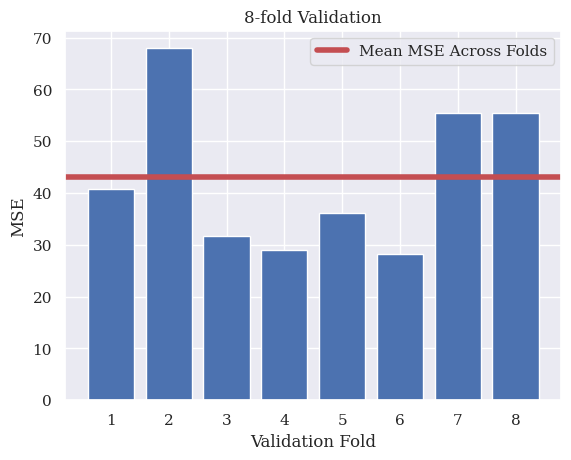

In [7]:
plt.bar(np.arange(1,len(val_mses)+1), val_mses)
plt.axhline(avg_mse, ls='-', lw=4, c='r', label="Mean MSE Across Folds")
plt.title(f"{k_folds}-fold Validation")
plt.xlabel("Validation Fold")
plt.ylabel("MSE")
plt.legend();

### K-fold Cross-Validation with scikit-learn's 'cross_validate()'


In [8]:
# Using cross_validate function on training data
model = LinearRegression()
scores = cross_validate(estimator=model,
                        X=X_train,
                        y=y_train,
                        cv=k_folds,
                        scoring='neg_mean_squared_error', # negative MSE because it maximizes
                        return_estimator=False,
                        return_train_score=False) 

# Convert negative MSE back to positive
avg_mse_sklearn = -np.mean(scores['test_score'])  # Despite the name, this is the validation score!!!
print(f"Average MSE using scikit-learn: {avg_mse_sklearn:.2f}")

Average MSE using scikit-learn: 43.06


In [9]:
# cross_validate returns a dictionary with values from each fold
scores

{'fit_time': array([0.00147486, 0.00092196, 0.00117707, 0.00150919, 0.00086284,
        0.00076103, 0.00078011, 0.00077367]),
 'score_time': array([0.00071025, 0.00060701, 0.00159311, 0.00063777, 0.00057101,
        0.00055313, 0.00053096, 0.00054932]),
 'test_score': array([-40.68413112, -67.92609524, -31.70086615, -28.96419135,
        -36.0689326 , -28.2243732 , -55.51815099, -55.35485044])}

---

### You might be wondering:

**"why neg_mean_squared_error"?**
  
*Answer:* In Scikit-learn, a general principle is that greater values should always correspond to better outcomes. This makes sense when thinking about scores like accuracy or R^2 where higher values are obviously better. However, when it comes to loss functions like Mean Squared Error (MSE), a lower value is better. So, to make it fit into Scikit-learn's general principle, the negative of the MSE is used. This way, larger values (which are less negative) still indicate better models. This principle is embedded in Scikit-learn's unified scoring API. 
When you perform hyperparameter tuning using something like GridSearchCV or RandomizedSearchCV, Scikit-learn tries to maximize the score. If you used a positive MSE, the optimization routine would erroneously try to maximize the MSE, which isn't what we want. By using a negative MSE, the optimization correctly tries to find a model that gets the "maximum" score, which corresponds to the minimum actual MSE.

**"Why use K-Fold and not e.g. LPOCV or LOOCV (Leave-P-Out or Leave-One-Out Cross Validation)?"**

*Answer:* LOOCV can be computationally expensive for large datasets, as it involves training a model n times (where n is the number of data points). K-Fold, especially with k=5 or 10, provides a good balance between computational cost and reliable estimation of model performance.

**In the manual cross-validation example, why didn't we shuffle the data?**

*Answer:* The manual example was a simplified demonstration. In many real-world scenarios, especially if the data has some order to it, you'd want to shuffle the data or use StratifiedKFold to maintain class distributions.

---

# Single-Fold Validation vs. Cross-Validation for kNN Model Selection 

Now let's try both single-fold validation and cross-validation as techniques to choose the best `k` value for a k-Nearest Neighbors (KNN) regression model.

## Single-Fold Validation

Single-fold validation is a simple technique where we split our data into three parts: training, validation, and test sets. We use the training set to fit our model, the validation set to evaluate and select the best model, and the test set for final evaluation.

In [10]:
# SINGLE-FOLD VALIDATION
# Create a separate 75/25 split for single fold validation
X_train_single, X_val_single, y_train_single, y_val_single = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=X_train.big_club_1)

# Perform single fold validation
single_fold_train_scores = []
single_fold_val_scores = []

k_values = range(1, 31) # Not to be confused with k-folds!!

knn = KNeighborsRegressor()

for k in k_values:
    # No need to create a new knn object each time
    knn.n_neighbors = k
    knn.fit(X_train_single, y_train_single)
    single_fold_train_scores.append(mean_squared_error(y_train_single, knn.predict(X_train_single)))
    single_fold_val_scores.append(mean_squared_error(y_val_single, knn.predict(X_val_single)))

## Cross-Validation

Cross-validation is more robust and makes better use of our data. Instead of using a single validation set, we divide our data into several folds and use each fold as a validation set once, while the remaining folds serve as the training set.

In this example, we'll use 8-fold cross-validation, training and validating our model 8 times for each `k` value, each time using a different fold as the validation set.

In [11]:
## CROSS-VALIDATION
cv_train_scores = []
cv_val_scores = []

# number of cv folds (to avoid confusion with knn's k)
cv = 8

for k in k_values:
    knn.n_neighbors = k
    
    # Cross-validation scores
    cv_results = cross_validate(knn, X_train, y_train, cv=cv, 
                                scoring='neg_mean_squared_error',
                                return_train_score=True)
    
    cv_train_scores.append(-cv_results['train_score'])  # Convert to positive MSE
    cv_val_scores.append(-cv_results['test_score'])    # Convert to positive MSE

# Calculate mean and standard error of cross-validation scores
train_means = np.mean(cv_train_scores, axis=1)
train_ses = np.std(cv_train_scores, axis=1, ddof=1) / np.sqrt(cv)  # Standard error
val_means = np.mean(cv_val_scores, axis=1)
val_ses = np.std(cv_val_scores, axis=1, ddof=1) / np.sqrt(cv)  # Standard error

## Visualizing the Results

Now that we've performed both single-fold validation and cross-validation, let's visualize the results. This will help us compare the two methods and understand their differences.

We'll create two plots side by side:
1. The cross-validation results, showing the mean training and validation MSE across all folds, with error bars representing one standard error.
2. The single-fold validation results, showing the training and validation MSE for our single split.

These plots will help us see how the model's performance changes with different `k` values and how the two validation methods compare:

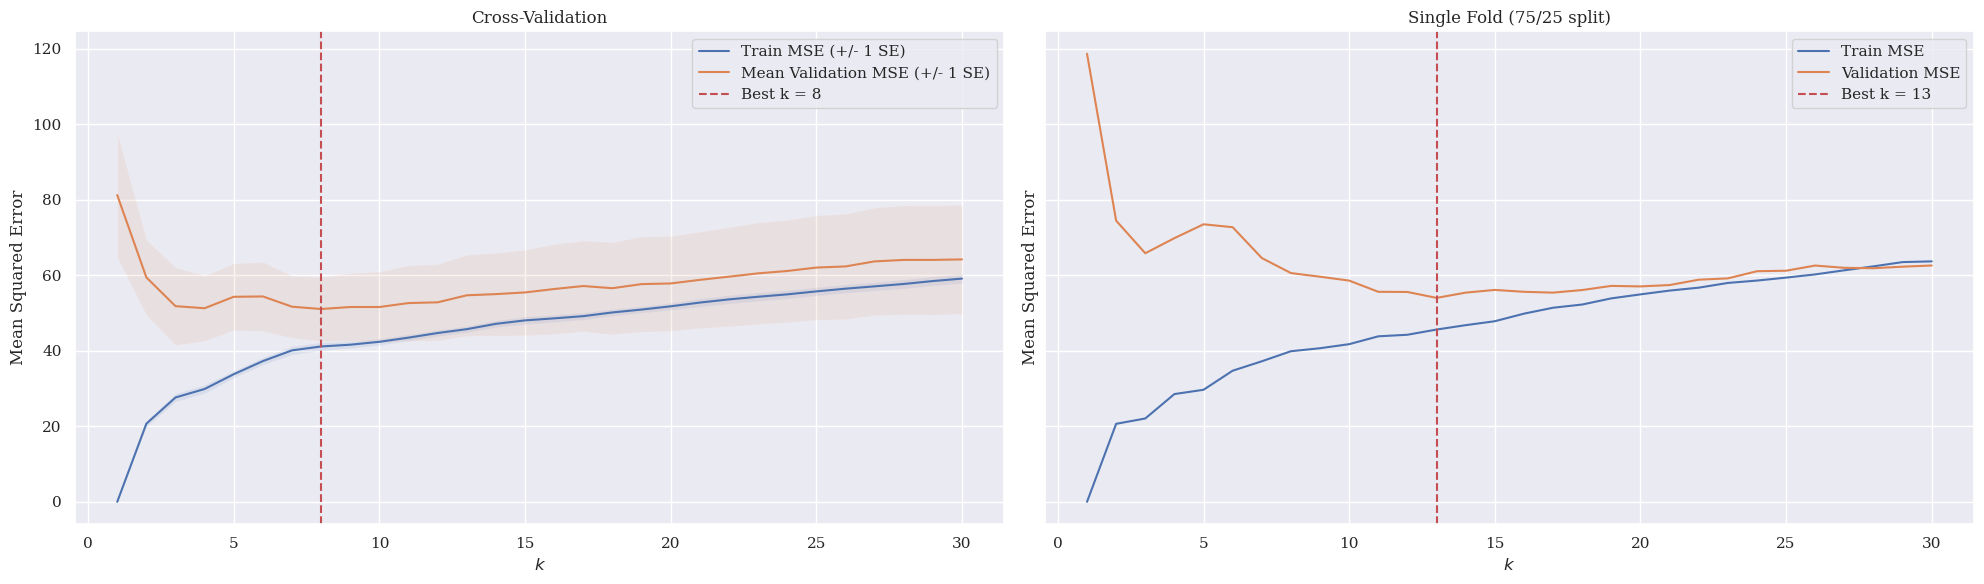

In [12]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Cross-validation plot
ax1.plot(k_values, train_means, label=f'Train MSE (+/- 1 SE)')
ax1.fill_between(k_values, train_means - train_ses, train_means + train_ses, alpha=0.1)
ax1.plot(k_values, val_means, label=f'Mean Validation MSE (+/- 1 SE)')
ax1.fill_between(k_values, val_means - val_ses, val_means + val_ses, alpha=0.1)
ax1.set_xlabel('$k$')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Cross-Validation')
ax1.legend()
ax1.grid(True)

# Find the best k from cross-validation
best_k_cv = k_values[np.argmin(val_means)]
ax1.axvline(best_k_cv, color='r', linestyle='--', label=f'Best k = {best_k_cv}')
ax1.legend()

# Single fold plot
ax2.plot(k_values, single_fold_train_scores, label='Train MSE')
ax2.plot(k_values, single_fold_val_scores, label='Validation MSE')
ax2.set_xlabel('$k$')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('Single Fold (75/25 split)')
ax2.legend()
ax2.grid(True)

# Find the best k from single fold
best_k_single = k_values[np.argmin(single_fold_val_scores)]
ax2.axvline(best_k_single, color='r', linestyle='--', label=f'Best k = {best_k_single}')
ax2.legend()

plt.tight_layout()

## Final Model Refitting and Evaluation

Now that we've selected the best $k$ value using both methods, it's crucial to understand that our model selection process is **not yet complete!** Here's why:

**Unused Information**: For the single-fold method, we've only used 75% of our training data to fit the model. For cross-validation, while we used all the data for validation, each fold's model was trained on only a subset of the data.

So we need to take two important last steps:

1. **Refit on All Training Data**: We'll train new models using the best $k$ values we found, but this time using all of our training data. This ensures we're using all available information to create our final models.

2. **Evaluate on the Test Set**: We'll use our held-out test set, which hasn't been used in any part of our model selection process, to get an unbiased estimate of our models' performance.

In [13]:
# Refit models with best k values and evaluate using R-squared
knn_cv = KNeighborsRegressor(n_neighbors=best_k_cv)
knn_single = KNeighborsRegressor(n_neighbors=best_k_single)

knn_cv.fit(X_train, y_train)
knn_single.fit(X_train_single, y_train_single)

# Evaluate on train and test sets using R-squared
X_test = design_test_df.copy()
train_r2_cv = r2_score(y_train, knn_cv.predict(X_train))
test_r2_cv = r2_score(y_test, knn_cv.predict(X_test))

train_r2_single = r2_score(y_train_single, knn_single.predict(X_train_single))
test_r2_single = r2_score(y_test, knn_single.predict(X_test))

print("\nFinal Results:")
print("=" * 50)
print(f"{'Model':<20} {'k':>5} {'Train R²':>10} {'Test R²':>10}")
print("-" * 50)
print(f"{'Cross-Validation':.<20} {best_k_cv:>5d} {train_r2_cv:>10.4f} {test_r2_cv:>10.4f}")
print(f"{'Single Fold':.<20} {best_k_single:>5d} {train_r2_single:>10.4f} {test_r2_single:>10.4f}")
print("=" * 50)


Final Results:
Model                    k   Train R²    Test R²
--------------------------------------------------
Cross-Validation....     8     0.7142     0.7717
Single Fold.........    13     0.6911     0.7550


We've seen how single-fold validation and cross-validation can lead to different model selections (k=13 vs k=8). The cross-validation approach generally provides a more robust estimate of model performance, as it uses all of the training data for validation in different iterations.

However, cross-validation is more computationally expensive, especially with large datasets or complex models. Single-fold validation can be a quicker alternative when computational resources are limited or when dealing with very large datasets.

<div id=boot style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>2 - Bootstrapping</h1> 


<img src="fig/bootstrap_example_rader.jpeg" alt="alt text" width="500" height="300" class="blog-image">


---

### Key Points for Bootstrapping:

1. **Sample Size Consistency:** 
    - **Key Takeaway:** The bootstrap dataset should have the same number of points as the original.
    - **Rationale:** This preserves the structure and variability of the original dataset in the bootstrap samples, ensuring that we are drawing from a distribution similar to our original data.

<div style="padding-top:0px;"></div>

2. **Sampling with Replacement:** 
    - **Key Takeaway:** We must sample with replacement; each time an item is selected, we put it back in the original dataset, so it may possibly be reselected.
    - **Rationale:** By sampling with replacement, each bootstrap sample is an independent draw from the original dataset. This captures the idea that we are trying to emulate the process of obtaining new samples from the population.

<div style="padding-top:0px;"></div>

3. **Extensive Iterative Sampling for Robust Bootstrapping Results:**
    - **Key Takeaway:** Typically, thousands of bootstrap samples are drawn (e.g., 10,000 or more) to obtain a reliable estimate of the distribution.
    - **Rationale:** The more replicates we draw, the better our approximation to the true distribution of the statistic. This ensures that our estimates, such as confidence intervals, are robust and reliable.

<div style="padding-top:0px;"></div>

4. **Limitations and Assumptions of Bootstrapping:**
    - **Key Takeaway:** While bootstrapping is versatile and powerful, it's not always the best approach for every situation.
    - **Rationale:** The bootstrap method assumes that the sample is a good representation of the population. If the original sample has biases or is not representative, the bootstrap samples will inherit these issues. 

<div style="padding-top:0px;"></div>

5. **Bootstrap and Confidence Intervals:**
    - **Key Takeaway:** One common use of bootstrapping is to construct confidence intervals, which provide a range of values that likely contain the true parameter value.
    - **Rationale:** Bootstrapped confidence intervals give a non-parametric way to estimate the range of possible values for a statistic without making strong assumptions about the shape or parameters of the true distribution.

---

### Bootstrap Implementation 
#### The laborious, but insightful way:

1. Choose random data points by randomly choosing indices.
2. Create subsets of the original data by choosing the DataFrame elements with the randomly chosen indices.

This could be achieved by using numpy's `random.choice()` pandas' `.iloc[]` method.

In [14]:
# Create example df  
example_X_df = X_train.head(5)
example_y_df = y_train.head(5)

# Generate random indices from example df
boot_i = np.random.choice(example_X_df.index, replace = True, size = len(example_X_df.index)) 

# Generate an X_train_boot data frame that contains exactly the observations with the boot_i indices.
# Print out the results of each line to understand what's going on. 
# Make sure that you understand why X_train_boot can contain the same index multiple times
X_train_boot = example_X_df.iloc[boot_i]
y_train_boot = example_y_df.iloc[boot_i]

display(X_train_boot)
display(y_train_boot)

,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,3.189224,0.378372,-1.962574,10.171150,1.206714,-6.259088,0.143166,-0.742584,3.851696,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.598459,-0.802292,0.838730,0.358153,0.480139,-0.501946,0.643673,-0.672907,0.703469,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.618215,1.152579,0.838730,2.618620,1.865120,1.357246,1.328438,0.966703,0.703469,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.618215,1.152579,0.838730,2.618620,1.865120,1.357246,1.328438,0.966703,0.703469,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.617032,1.075158,-0.179926,0.380728,-0.663406,0.111020,1.155965,-0.193449,0.032373,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,market_value
0,18.0
4,1.0
1,22.0
1,22.0
2,5.0


#### The fast way (if your training data wasn't split into X and y):

1. Instead of calculating indices manually and using .iloc to grab the respective rows, you could also use pandas' built-in `.sample()` method
2. However, since you don't have the indices to also grab the respective y_train_boot values in this case, you'd have to combine example_df and y_train

In [15]:
# Create an example dataframe
example_X_df = X_train.head(5)

# Take the corresponding rows from y_train and add it to the example_df
example_X_y_df = example_X_df.copy()
example_X_y_df['target'] = y_train.head(5)

# Bootstrapping using pandas' sample method
boot_df = example_X_y_df.sample(frac=1, replace=True)

# Split the bootstrapped dataframe back into X_train_boot and y_train_boot
X_train_boot = boot_df.drop(columns='target')
y_train_boot = boot_df['target']

# display(X_train_boot)
# display(y_train_boot)

<div class="alert alert-success">
<h3>Your turn! (10 mins)</h3> 

Complete the code inside the loop below. Make sure to create a new bootstrap sample in every iteration, fit a linear regression model. Store the model in `boot_models` as well as the coefficients.

In [21]:
# Configure number of bootstraps
n_boots = 1000

# Lists to save models and coefficients
boot_models = []
boot_betas = []

np.random.seed(42)
for i in range(n_boots):
   
    # Randomly sample indices with replacement to create bootstrap samples
    # your code here
    boot_i = np.random.choice(X_train.index, replace = True, size = X_train.shape[0]) 

    # Create bootstrap datasets for features and target variable using the sampled indices
    X_train_boot = X_train.loc[boot_i]
    y_train_boot = y_train.loc[boot_i]
    
    # Train a linear regression model on the bootstrap sample
    boot_linreg = LinearRegression().fit(X_train_boot, y_train_boot)

    # Save the trained model
    boot_models.append(boot_linreg)
    
    # Extract and save coefficients from the trained model (including the intercept)
    coefs = np.insert(boot_linreg.coef_[0], 0, boot_linreg.intercept_[0], axis=None)
    boot_betas.append(coefs)

In [6]:
## load solutions if stuck
# %load snips/boot.py

In [22]:
# Store betas in df with feature names
feature_names_final = ['intercept'] + list(X_train.columns)
boot_betas_df = pd.DataFrame(boot_betas, columns=feature_names_final)

<div class="alert alert-success">
<h3>Next Steps</h3> 

if you have some time left, look into the following next steps. We will do this interactively in class.

1. **Examine the Coefficients:** Take a closer look at the boot_betas to understand the distribution and variability of our bootstrapped coefficients.

2. **Comparing Columns:** Determine the number of columns in boot_betas & the number of columns in X_train.

<div style='padding:0px'></div>

3. **Investigate Discrepancies:** Can you explain the difference in the number of columns between boot_betas and X_train?
  
<div style='padding:0px'></div>

4. **Action Plan:** What steps do you think we need to take next, based on the results and discrepancies you've observed?

### Explore

In [23]:
boot_betas_df.describe()

,intercept,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.229779,5.101826,2.805237,-1.275295,-0.269190,0.898743,-1.149851,0.955549,-0.814258,-1.748275,0.993464,0.124198,0.204878,1.783241,6.682837,0.909497,1.624799,0.992212
std,0.913074,1.151826,0.546764,0.379224,0.415263,0.874602,0.720636,0.741002,0.545622,0.260821,0.793380,0.812479,1.216559,0.952485,1.156478,0.699795,1.482962,0.952831
min,5.476023,1.478345,0.577826,-2.442839,-2.956316,-2.124173,-3.457227,-1.301204,-2.687769,-2.654777,-3.003506,-2.560641,-3.127895,-1.461032,2.502805,-1.560143,-3.843313,-2.190179
25%,7.643451,4.297171,2.442025,-1.530432,-0.451630,0.325154,-1.623895,0.403646,-1.169518,-1.922625,0.468404,-0.420629,-0.638666,1.106660,5.883951,0.459610,0.663086,0.362330
50%,8.207478,5.051157,2.828131,-1.281890,-0.231296,0.924208,-1.151954,0.967970,-0.805467,-1.725363,0.995337,0.141326,0.186532,1.787904,6.741315,0.916463,1.605958,0.944826
75%,8.812577,5.896549,3.181927,-1.019768,-0.039464,1.528161,-0.638208,1.450735,-0.441547,-1.575267,1.491718,0.698750,1.019203,2.420201,7.492192,1.359470,2.670018,1.637206
max,10.757989,9.515844,5.141050,0.049689,1.172620,3.906567,1.085565,3.666970,0.861679,-0.981915,3.746476,3.064780,3.692005,4.505171,10.286583,3.130712,6.841356,3.639094


<div id=ci style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>3 - Bootstrap Confidence Intervals</h1> 


After bootstrapping and obtaining a distribution of coefficients for each feature, a logical next step is to compute confidence intervals. Confidence intervals provide a range of values, derived from the bootstrapped data, in which we expect the true parameter (in this case, the coefficient) to lie, with a certain level of confidence.

**Why is this useful?**

- **Interpretability**: Confidence intervals help us understand the uncertainty and variability associated with our estimates. A narrower confidence interval indicates a more reliable estimate, while a wider interval suggests more uncertainty.
  
- **Statistical Significance**: By examining whether a confidence interval for a coefficient includes zero, we can make inferences about the statistical significance of that coefficient. If zero isn't in the interval, we might infer the corresponding feature has a significant association with the target.

- **Comparisons**: By comparing the confidence intervals of different coefficients, we can gauge which features have more influence or certainty associated with their effects.

In the following code, we will compute the 95% confidence intervals for each feature's coefficient. This means that we are 95% confident that the true coefficient lies within the provided range.

---


<div class="alert alert-success">
<h3>TASK: Find the 95% bootstrap confidence intervals for the coefficients</h3> 

In [25]:
# Initialize an empty list to store statistics for each feature
stats_list = []

feature_names_final = X_train.columns

# Loop through each feature to compute its bootstrapped statistics
for i in range(len(feature_names_final)):
    
    # Extracting the bootstrapped coefficient values for the current feature
    betavals = boot_betas_df.iloc[:, i]
    
    # Sorting the coefficient values to aid in percentile calculation
    betavals.values.sort()
    
    # Calculating the 2.5th percentile - lower bound of the 95% CI
    # your code here
    x1 = np.round(np.percentile(betavals, 2.5), 2)
    
    # Calculating the 97.5th percentile - upper bound of the 95% CI
    x2 = np.round(np.percentile(betavals, 97.5), 2)
    
    # Calculating mean and standard deviation of the bootstrapped coefficients
    mean = np.round(np.mean(betavals),2)
    std = np.round(np.std(betavals),2)
    
    # Appending computed statistics for current feature to the stats_list
    stats_list.append([feature_names_final[i], mean, std, x1, x2])

# Convert the stats_list into a dataframe for easy visualization and analysis
boot_beta_df = pd.DataFrame(stats_list, columns=['feature', 'boot_mean', 'boot_std', '95_low', '95_high'])

# Display the final dataframe with bootstrapped statistics and confidence intervals
boot_beta_df

,feature,boot_mean,boot_std,95_low,95_high
0,page_views,8.23,0.91,6.36,10.10
1,fpl_points,5.10,1.15,3.02,7.47
2,age,2.81,0.55,1.73,3.86
3,page_views^2,-1.28,0.38,-2.00,-0.55
4,page_views fpl_points,-0.27,0.42,-1.43,0.42
5,page_views age,0.90,0.87,-0.86,2.53
6,fpl_points^2,-1.15,0.72,-2.63,0.19
7,fpl_points age,0.96,0.74,-0.42,2.47
8,age^2,-0.81,0.55,-1.90,0.23
9,position_cat_2,-1.75,0.26,-2.29,-1.27


In [ ]:
## load solutions if stuck
# %load snips/boot-ci.py

#### Now let's plot the confidence intervals for a couple of the feature coefficients

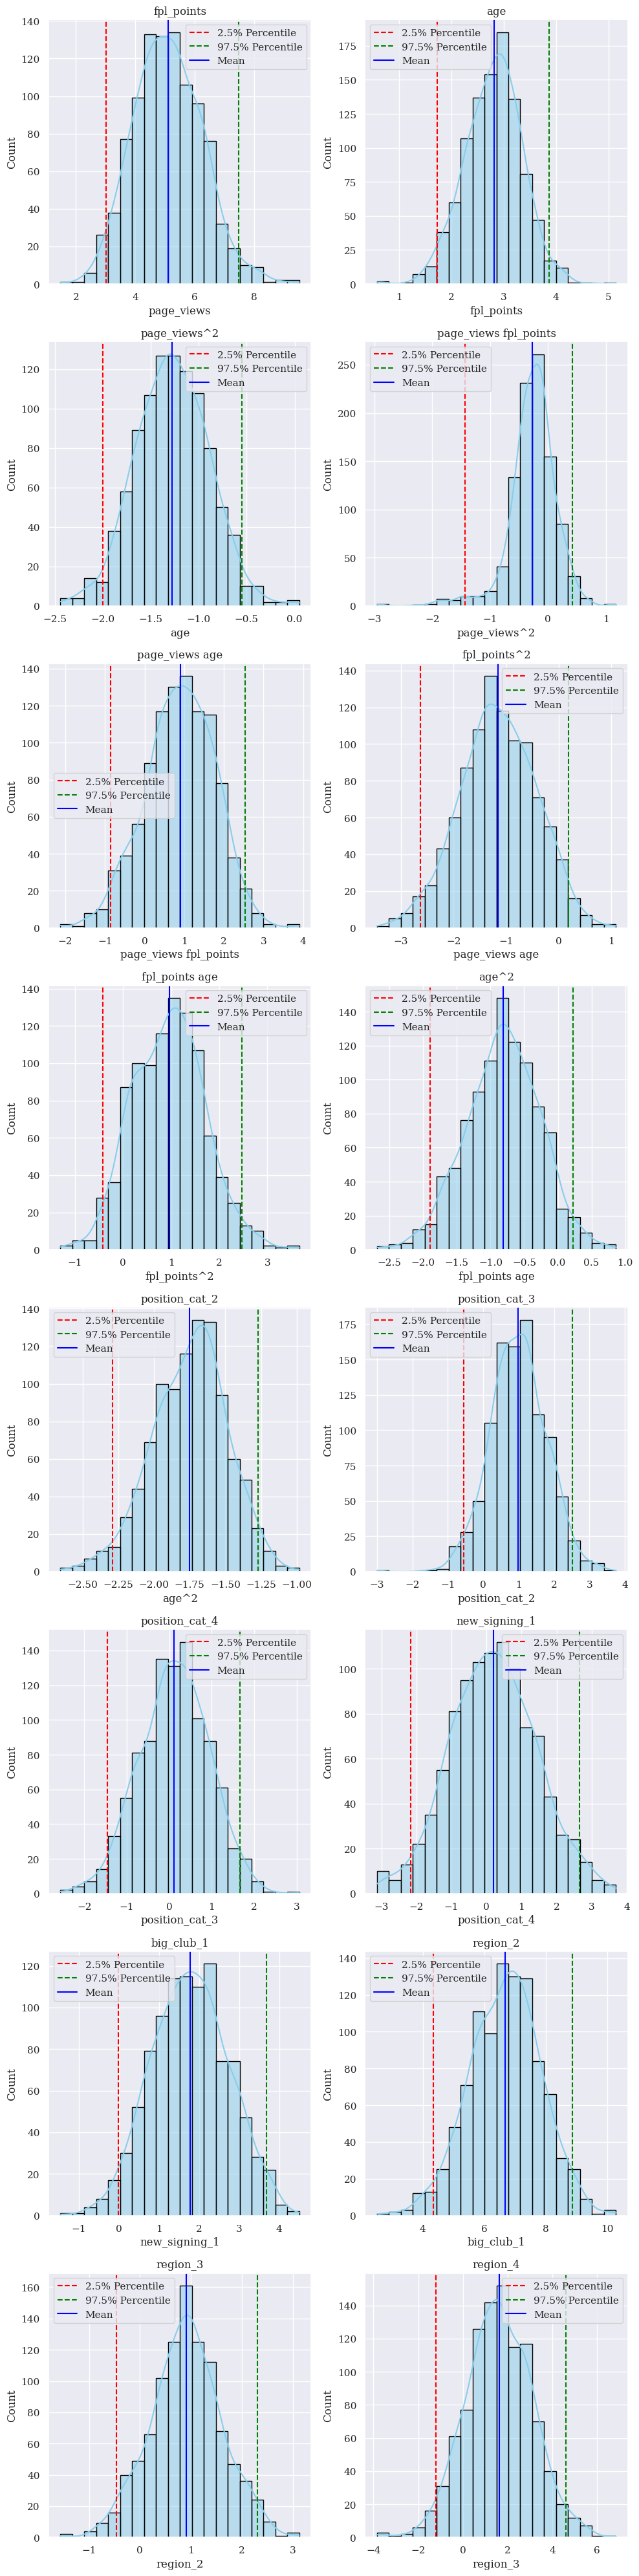

In [26]:
# Setting up the figure and axes
fig, axs = plt.subplots(8, 2, figsize=(10, 40))
axs = axs.ravel()

# Looping through each feature to plot histograms and confidence intervals
# Starting from 1 to exclude the intercept (assuming x0 is the first column)
for i, (index, row) in enumerate(boot_beta_df.iloc[1:].iterrows()):
    sns.histplot(boot_betas_df.iloc[:, i+1], bins = 20, ax=axs[i], kde=True, color='skyblue', edgecolor='black')
    axs[i].axvline(row['95_low'], color='red', linestyle='--', label='2.5% Percentile')
    axs[i].axvline(row['95_high'], color='green', linestyle='--', label='97.5% Percentile')
    axs[i].axvline(row['boot_mean'], color='blue', linestyle='-', label='Mean')
    axs[i].set_title(row['feature'])
    axs[i].legend()

# Adjusting layout
plt.tight_layout()

<div id=feature style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>4 - Feature importance</h1> 

Let's try and determine how 'important' our predictors are interms of their relationship to the response variable using the bootstrapped beta values in DataFrame `boot_beta_df`. First we sort the values.

In [ ]:
sorted_boot_beta_df = boot_beta_df.sort_values(by=['boot_mean'], ascending=True)
sorted_boot_beta_df

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4)) 

# Sort the dataframe by absolute value of boot_mean, excluding the intercept
sorted_boot_beta_df = boot_beta_df.iloc[:-1].sort_values('boot_mean', key=abs, ascending=True)

# Create horizontal bar plot
bars = ax.barh(sorted_boot_beta_df['feature'], sorted_boot_beta_df['boot_mean'], 
               align='center', color="#336600", alpha=0.7)

# Add error bars
ax.errorbar(sorted_boot_beta_df['boot_mean'], sorted_boot_beta_df['feature'],
            xerr=sorted_boot_beta_df['boot_std'], fmt='none', ecolor='black', capsize=5, alpha=.4)

# Customize the plot
ax.grid(linewidth=0.2, axis='x')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Predictors')
ax.set_title('Bootstrap Coefficient Values')

plt.tight_layout()

#### Now let's find the feature importance using the t-values 

(NOTE: The lambda function here takes a row of the DataFrame as input and returns the result of dividing 'boot_mean' by 'boot_std'. axis=1: This argument indicates that the function should be applied to rows, not columns.

In [ ]:
# creating a new column with the t-values  
sorted_boot_beta_df['t'] = sorted_boot_beta_df.apply(lambda row: 
                                         row['boot_mean']/row['boot_std'], axis=1)
sorted_boot_beta_df = sorted_boot_beta_df.sort_values('t', key=abs)
sorted_boot_beta_df.head(2)

In [ ]:
fig, ax = plt.subplots()
ax.barh(sorted_boot_beta_df['feature'].iloc[:-1], sorted_boot_beta_df['t'].iloc[:-1], 
        align='center', color="#336600", alpha=0.7)
ax.grid(linewidth=0.2)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Predictors')
ax.set_title('Feature Importance based on $\hat{t}-$test')
plt.show()

<div id=coeff_interpretation style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>5 - Linear Regression Coefficient Interpretation (with statsmodels)</h1> 

Say we have input features $X$, which via some function $f()$, approximates outputs $Y$. That is, $Y = f(X) + \epsilon$.

- **Inference**: estimates the function $f$, and is more concerned with understanding the relationship between $X$ and $Y$.
- **Prediction**: the goal is making accurate $Y$ predictions for some unseen $X$.


#### Two popular and useful libraries in Python are `sklearn` and `statsmodels`.

`statsmodels` is mostly focused on the _inference_ task. It aims to make good estimates for $f()$ (via solving for our $\beta$'s), and it provides expansive details about its certainty. It provides lots of tools to discuss confidence, but isn't great at dealing with test sets.

`sklearn` is mostly focused on the _prediction_ task. It aims to make a well-fit line to our input data $X$, so as to make good $Y$ predictions for some unseen inputs $X$. It provides a shallower analysis of our variables. In other words, `sklearn` is great at test sets and validations, but it can't really discuss uncertainty in the parameters or predictions.

#### Let's try `statsmodels` now.

`statsmodels` linear regression does not include an intercept by default, so, if needed, we add one using:
```
X_train = sm.add_constant(X_train)
sm.OLS(y,X_train)
```
where Xtrain is our train set and y our return variable. 

Watch for additional intercepts coming from, e.g. Polynomial features. Have only one intercept. In our case we do have one, so we are not adding another one. 

#### Let's load a clean set of data

In [ ]:
X_train = pd.read_csv("data/design_train_df.csv")
y_train = pd.read_csv("data/y_train.csv")

X_test = pd.read_csv("data/design_test_df.csv")
y_test = pd.read_csv("data/y_test.csv")

Unlike sklearn's LinearRegression, statsmodels' OLS doesn't give you the column of ones 'for free' You need to add it to the X data using `sm.add_constant`

In [ ]:
import statsmodels.api as sm
from statsmodels.api import OLS

# your code here
X_train = sm.add_constant(...)
ols = OLS(y_train, np.array(X_train))
results = ols.fit()
# get the parameters
results.params 

In [ ]:
## load solutions if stuck
# %load snips/ols.py

Can we recover the feature names for readability?

In [ ]:
feature_names = list(X_train.columns)
feature_names

In [ ]:
results_df = pd.DataFrame(zip(feature_names, results.params), columns=['feature', 'coeff'])
results_df

With `statsmodels` we can print more statistics than we need!
```
results.summary()
```
If we want human-readable feature names we need to set the parameter `xname`
```
results.summary(xname = a list of names)
```

In [ ]:
results.summary(xname=feature_names)

<div class="alert alert-success">
    <strong> 💬 DISCUSSION:</strong> How do the bootstrap confidence intervals compare with the ones derived by `statsmodels` which are based on the Student’s t-distribution? </div> 

Bootstrap confidence intervals and confidence intervals derived from the Student's \( t \)-distribution (as used in `statsmodels`) are two different methods to estimate the precision and uncertainty of parameter estimates in statistical models. Let's delve into both methods a bit:

Bootstrap Confidence Intervals:
1. Non-Parametric Approach:
   - The bootstrap method does not assume that the data follows any particular distribution.
2. Resampling Technique:
   - It involves repeatedly resampling, with replacement, from the observed data, and then recalculating the estimate of interest on each resample.

Confidence Intervals using Student’s \( t \)-Distribution (e.g., in `statsmodels`):
1. Parametric Approach:
   - Assumes the estimators of the model parameters are normally distributed or follow a Student’s \( t \)-distribution, especially in smaller sample sizes.
2. Model-Based Standard Errors:
   - Utilizes the standard errors calculated based on model assumptions (like independence of errors in OLS regression) to compute confidence intervals.
3. Analytical Solution:
   - It uses an analytical solution based on the underlying statistical theory, making it computationally less intensive than bootstrap.
Comparison:
Bootstrap can be applied to a wider range of statistics, including those for which there is no straightforward analytical method for calculating confidence intervals. The \( t \)-distribution method might be limited to parameters for which there are well-established methods for calculating standard errors under model assumptions. Also, Bootstrap might be preferred for deriving confidence intervals for complex statistics or in the absence of theoretical distributions. \( t \)-distribution intervals might be preferred for simplicity and speed when model assumptions are valid.

<div class="alert alert-success">
    <strong> 💬 DISCUSSION:</strong> What conclusions can we make from the values of the model coefficients as to the relationship between our response variable y and the features? </div> 



<div id=model style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>6 - Model Selection for Ridge and LASSO (example code).</h1> 

We are interested in the generalization performance of a learning method which shows as the prediction capability on an independent test data. This performance guides our choice of learning model, and gives us a measure of the quality of the ultimately chosen model. If we are in a data-rich situation, the best approach for both problems is to randomly divide the dataset into three parts: a training set, a validation set, and a test set. The training set is used to fit the models; the validation set is used to estimate prediction error for model selection; the test set is used for assessment of the generalization error of the final chosen model.

- **Model selection**: estimating the performance of different models in order to choose the best one.
- **Model assessment**: having chosen a final model, estimating its predic- tion error (generalization error) on new data.
<p style="text-align:right"><font size="1"; text-align='right'>(The Elements of Statistical Learning (2009)</font></p>

### Ridge regression using a validation set. 

#### Let's load a clean set of data

In [ ]:
X_train = pd.read_csv("data/design_train_df.csv")
y_train = pd.read_csv("data/y_train.csv")

X_test = pd.read_csv("data/design_test_df.csv")
y_test = pd.read_csv("data/y_test.csv")

In [ ]:
X_train.head(2)

In [ ]:
# Split the data into train and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  train_size=0.8, 
                                                  random_state=42
                                                  )

X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
# List of hyper-parameter values 
alphas = np.logspace(0, 2.5, 100)

# List to store training errors
training_error = []
# List to store validation errors
validation_error = []

fit_intercept = True

for i, alpha in enumerate(alphas):
    
    # For each i, fit a ridge regression on training set
    ridge_reg = Ridge(fit_intercept=fit_intercept, 
                      alpha=alpha,
                      #max_iter=max_iter
                     )
    ridge_reg.fit(X_train, y_train)

    # Predict on the train and validation set 
    y_train_pred = ridge_reg.predict(X_train)
    y_val_pred = ridge_reg.predict(X_val)
    
    # Compute the training and validation MSE
    mse_train = mean_squared_error(y_train, y_train_pred) 
    mse_val = mean_squared_error(y_val, y_val_pred)
    
    # Add that value to the list 
    training_error.append(mse_train) 
    validation_error.append(mse_val) 

In [ ]:
# find the best parameter
best_alpha = alphas[validation_error.index(min(validation_error))]
print("Ridge Best Alpha:", best_alpha)

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(alphas, training_error, label='Training Error');
ax.plot(alphas, validation_error, label='Validation Error');
ax.axvline(best_alpha, c='k', ls=':', label=f"Best Alpha: {best_alpha:.2f}")

ax.set_xlabel('Ridge tuning parameter (alpha)', fontsize=10)
ax.set_ylabel('mse', fontsize=10)

ax.set_title('Ridge Regression mse in train and test set', fontsize=12)
ax.grid(":", alpha=0.4)

ax.legend(loc='best')
plt.tight_layout()

#### Let's re-fit the model on the whole dataset

In [ ]:
# We should use all the dataset now, training+validation
final_ridge_model = Ridge(alpha=best_alpha).fit(X_train, y_train)

#### Let's do the final assessment on the test set

In [ ]:
y_test_pred = final_ridge_model.predict(X_test)
r2_test = final_ridge_model.score(X_test, y_test)
print(f'R^2 test = {r2_test:.3}')

### Lasso regression using cross validation. 

In [ ]:
# Set parameters for cross-validation
alphas = np.logspace(-3, 0, 100)
fit_intercept = True
# Maximum number of iterations to run 
# before it converges.
max_iter = 1000

lasso_coefficients = []
k = 5
num_est = 0
# store MSE results
results = []

training_error = []
validation_error = []
validation_std = []

for alpha in alphas:

    lasso_reg = Lasso(
                fit_intercept=fit_intercept, 
                alpha=alpha, 
                #max_iter=max_iter
    )
    
    lasso_cv = cross_validate(
                lasso_reg,
                X_train, 
                y_train, 
                cv=k, 
                scoring="neg_mean_squared_error",
                return_train_score=True,
                return_estimator=True
    )
    
    training_error.append(                       
        np.mean(-lasso_cv['train_score'])
    )
    
    validation_error.append(
        np.mean(-lasso_cv['test_score'])
    )
    
    validation_std.append(
        np.std(lasso_cv['test_score'])
    )
    
    lasso_coefficients.append(
         lasso_cv['estimator']
    )

In [ ]:
# find the best parameter
min_cross_val_mse = min(validation_error)
best_cross_val_alpha = alphas[validation_error.index(min_cross_val_mse)]
min_cross_val_mse, best_cross_val_alpha

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(alphas, training_error, label='training error');
ax.plot(alphas, validation_error, label='validation error');
ax.axvline(best_cross_val_alpha, c='k', ls=':', label=f"Best Alpha: {best_cross_val_alpha:.2f}")


ax.set_xlabel('Lasso tuning parameter (alpha)', fontsize=10)
ax.set_ylabel('mse', fontsize=10)

ax.set_title('Lasso Regression mse in train and validation set', fontsize=12)
ax.grid(":", alpha=0.4)

ax.legend(loc='best')
ax.set_xscale('log')
plt.tight_layout()

#### Let's re-fit the model on the whole dataset

In [ ]:
# We should use all the dataset now, training+validation
cross_lasso_model = Lasso(alpha=best_cross_val_alpha).fit(X_train, y_train)

#### Evaluate on the test set

In [ ]:
y_test_pred = cross_lasso_model.predict(X_test)
r2_test = cross_lasso_model.score(X_test, y_test)
print(f'R^2 test = {r2_test:.3}')

In [ ]:
# Notice the zeroed coefs from LASSO
cross_lasso_model.coef_

### Ridge and lasso regression using built-in cross validation in `sklearn`

In [ ]:
X_train = pd.read_csv("data/design_train_df.csv")
y_train = pd.read_csv("data/y_train.csv")

X_test = pd.read_csv("data/design_test_df.csv")
y_test = pd.read_csv("data/y_test.csv")

In [ ]:
X_train.head(2)

In [ ]:
# Set parameters for cross-validation
ridge_alphas = np.logspace(0, 2.75, 500)
lasso_alphas = np.logspace(-3, 0, 500)

# These CV models refit on the full training data
# using the best alpha found during cross-validation!
ridge = RidgeCV(alphas=ridge_alphas, cv=k).fit(X_train, y_train)
lasso = LassoCV(alphas=lasso_alphas, cv=k).fit(X_train, y_train)

# Best alphas & test scores
ridge_a = ridge.alpha_
print('Best alpha for ridge: {}'.format(ridge_a))
print(f'R^2 score for Ridge with alpha={ridge_a}: {ridge.score(X_test, y_test):.3}')

lasso_a = lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print(f'R^2 score for Lasso with alpha={lasso_a}: {lasso.score(X_test, y_test):.3}')